In [299]:
import torch
from torch import nn
import gpytorch
# from torchsummary import summary

import matplotlib.pyplot as plt
import gc

from warp_units import *
from func_polygon import *
from func_data_generation import *

from utils import *

dtype=torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
# device =  "cpu"
print("Using {} device".format(device))

import tqdm
torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using cuda device
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [331]:
class WarpModel(torch.nn.Sequential):
    def __init__(self):
        super(WarpModel, self).__init__()
        self.add_module('axial_dim0', AxialWarpUnit(dim=0, res=50, grad=20, lims=[0, 1.0]))
        self.add_module('axial_dim1', AxialWarpUnit(dim=1, res=50, grad=20, lims=[-1.0, 0]))
        self.add_module('rbf_seq1', rbfunit_sequential(res=1, ylim=[-1.0, 0.0]))
        self.add_module('rbf_seq2', rbfunit_sequential(res=2, ylim=[-1, 0]))
        self.add_module('mobius', MobiusWarpUnit())
        
        
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, warp_model):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
#             self.covar_module = gpytorch.kernels.GridInterpolationKernel(
#                 gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
#                 num_dims=2, grid_size=100
#             )
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            self.covar_module2 = gpytorch.kernels.LinearKernel() * gpytorch.kernels.LinearKernel()
            self.space_transform = warp_model

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.space_transform(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x) + self.covar_module2(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [332]:
train_X = torch.load(DATA_PATH+ '/train_X').to(device)
train_y = torch.load(DATA_PATH+ '/train_y').to(device)

In [333]:
train_X

tensor([[ 0.7350, -0.9150],
        [ 0.3150, -0.9750],
        [ 0.0150, -0.0250],
        [ 0.7450, -0.4850],
        [ 0.9450, -0.1450],
        [ 0.9450, -0.0650],
        [ 0.7750, -0.3450],
        [ 0.2050, -0.6650],
        [ 0.0850, -0.6650],
        [ 0.8650, -0.5550],
        [ 0.5850, -0.4450],
        [ 0.3050, -0.6050],
        [ 0.4750, -0.3650],
        [ 0.2750, -0.0550],
        [ 0.2350, -0.1650],
        [ 0.5050, -0.9550],
        [ 0.0750, -0.7150],
        [ 0.0350, -0.7050],
        [ 0.8550, -0.0650],
        [ 0.4850, -0.9750],
        [ 0.2450, -0.1850],
        [ 0.6250, -0.0650],
        [ 0.4350, -0.6050],
        [ 0.9950, -0.5150],
        [ 0.0950, -0.1250],
        [ 0.1050, -0.0850],
        [ 0.7850, -0.8150],
        [ 0.6050, -0.2950],
        [ 0.3050, -0.3550],
        [ 0.2750, -0.0850],
        [ 0.4350, -0.8050],
        [ 0.6150, -0.0850],
        [ 0.0450, -0.7250],
        [ 0.7850, -0.1550],
        [ 0.2050, -0.6950],
        [ 0.8450, -0

In [334]:
warp_model = WarpModel().to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp_model = GPRegressionModel(train_x=train_X, train_y=train_y, likelihood=likelihood, warp_model=warp_model).to(device)
gp_model.covar_module.outputscale = 13

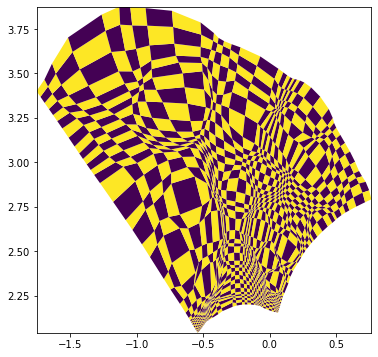

In [335]:
chessboard_from_model(warp_model)

In [336]:
# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
# #     print(f"Layer:{name} | Size:{param.size()} |  \n")

In [345]:
gp_model.train()
likelihood.train()
training_iterations = 1000
# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': gp_model.space_transform.parameters()},
    {'params': gp_model.covar_module.parameters()},
    {'params': gp_model.mean_module.parameters()},
    {'params': gp_model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = gp_model(train_X)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        iterator.set_postfix(loss=loss.item(), output_scale = gp_model.covar_module.outputscale.item(), 
                             leng_scale = gp_model.covar_module.base_kernel.lengthscale.item(), noise=gp_model.likelihood.noise.item())
        optimizer.step()

%time train()

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 53min 8s, sys: 1min 14s, total: 54min 22s
Wall time: 1min 21s


In [346]:

# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")

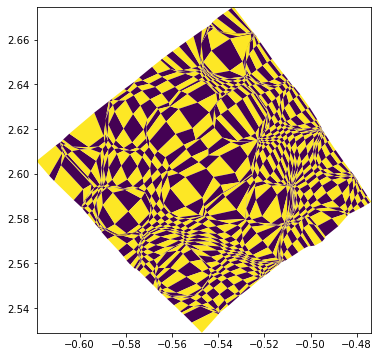

In [347]:
chessboard_from_model(warp_model)

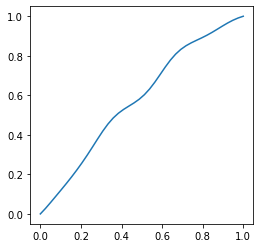

In [348]:
oned_map(warp_model.axial_dim0, dim=0)

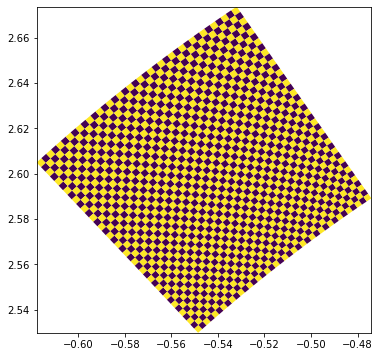

In [349]:
chessboard_from_model(warp_model.mobius)

In [350]:
for name, param in gp_model.named_parameters():
    print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
#     print(f"Layer:{name} | Size:{param.size()} |  \n")


Layer:likelihood.noise_covar.raw_noise | Size:torch.Size([1]) | Values : Parameter containing:
tensor([2.4801], device='cuda:0', requires_grad=True) 

Layer:covar_module.raw_outputscale | Size:torch.Size([]) | Values : 28.863210729505564 

Layer:covar_module.base_kernel.raw_lengthscale | Size:torch.Size([1, 1]) | Values : Parameter containing:
tensor([[-0.2494]], device='cuda:0', requires_grad=True) 

Layer:covar_module2.kernels.0.raw_variance | Size:torch.Size([1, 1]) | Values : Parameter containing:
tensor([[0.]], device='cuda:0', requires_grad=True) 

Layer:covar_module2.kernels.1.raw_variance | Size:torch.Size([1, 1]) | Values : Parameter containing:
tensor([[0.]], device='cuda:0', requires_grad=True) 

Layer:space_transform.axial_dim0.weight_true | Size:torch.Size([1, 50]) | Values : Parameter containing:
tensor([[-3.1338,  2.9853,  1.0573,  0.9914, -1.5959, -1.4684, -0.1458,  1.6435,
          2.1127,  0.5454,  0.9362,  0.1868, -0.0440,  2.3597,  1.1194,  2.8167,
          1.0119

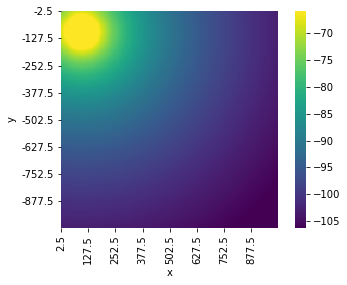

In [351]:
likelihood.eval()
gp_model.eval()
coords, rss = get_field_data(200, 30, torch.tensor([[100, -100]]))  # 200*200显存上限
coords = coords.to(device)
observed_pred = likelihood(gp_model(coords/1000))
mean = observed_pred.mean.detach()
var = observed_pred.variance.detach()

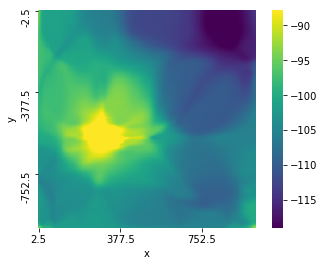

In [352]:
plot_heatmap(coords, mean)

In [344]:
gp_model.set_train_data(train_X, train_y, strict=False)

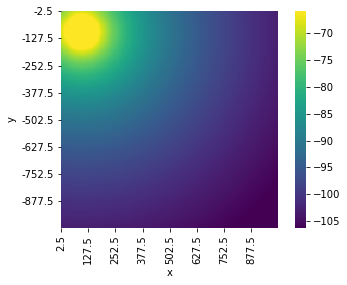

In [297]:
likelihood.eval()
gp_model.eval()
coords, rss = get_field_data(200, 30, torch.tensor([[100, -100]]))  # 200*200显存上限
coords = coords.to(device)
observed_pred = likelihood(gp_model(coords/1000))
mean = observed_pred.mean.detach()
var = observed_pred.variance.detach()

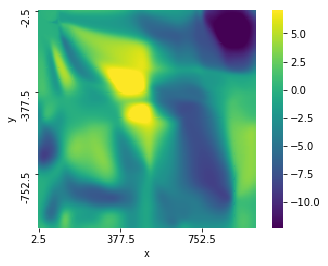

In [298]:


plot_heatmap(coords, mean)

In [21]:
point = torch.tensor([[2.5, -2.5]]).to(device)
warp_model(point)

tensor([[ 2.6314, -1.8408]], device='cuda:0', grad_fn=<StackBackward>)

In [353]:
gp_model.covar_module2

ProductKernel(
  (kernels): ModuleList(
    (0): LinearKernel(
      (raw_variance_constraint): Positive()
    )
    (1): LinearKernel(
      (raw_variance_constraint): Positive()
    )
  )
)